In [188]:
import sys
import pickle
import matplotlib.pyplot as plt

from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/bruno-pacheco/brain-age')

from tqdm.notebook import tqdm

import numpy as np

In [2]:
import wandb

import torch
from torchvision import models
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age', model_fname='model_last'):
    best_model_file = wandb.restore(
        model_fname+'.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [3]:
import h5py

from torch.utils.data import Dataset
from torchvision import transforms


class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=transforms.ToTensor(),
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

        # transform
        if self.transform:
            img = self.transform(img)

        return img, label

val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='val')
len(val_data) / 40

561.0

In [190]:
net = torch.load(PROJ_ROOT/'models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '1tz3p1dw').to(device)  # pre-trained, linear lr decay
net.eval()
pass

In [5]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=40, shuffle=False)

In [28]:
X, y = next(iter(val_dataloader))
X, y = X[20].to(device).unsqueeze(0), y[20].to(device).unsqueeze(0)

y_pred = net(X).unsqueeze(0)

plt.imshow(X.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

print(y_pred.item(), y.item())

75.58016967773438 73


In [6]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap

In [41]:
X.max()

tensor(2.1622, device='cuda:0')

In [42]:
X.min()

tensor(-2.2978, device='cuda:0')

In [51]:
integrated_gradients = IntegratedGradients(net)
attributions_ig = integrated_gradients.attribute(X, n_steps=200)

# default_cmap = LinearSegmentedColormap.from_list('custom blue', 
#                                                  [(0, '#ffffff'),
#                                                   (0.25, '#000000'),
#                                                   (1, '#000000')], N=256)

X_ = X + X.min()
X_ = X_ / X_.max()

_ = viz.visualize_image_attr(attributions_ig.squeeze().unsqueeze(-1).cpu().detach().numpy(),
                             X_.squeeze().unsqueeze(-1).cpu().detach().numpy(),
                             method='blended_heat_map',
#                              cmap=default_cmap,
                             show_colorbar=True,
                             sign='all',
                             outlier_perc=1,
                            )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

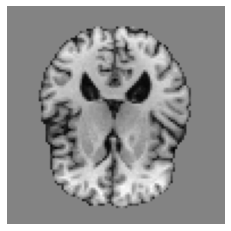

77.07610321044922 73


In [191]:
X, y = next(iter(val_dataloader))
X, y = X.to(device), y.to(device)

y_pred = net(X)

plt.imshow(X[20].squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

print(y_pred.mean().item(), y[0].item())

In [192]:
# integrated_gradients = IntegratedGradients(net)
attributions_ig = IntegratedGradients(net).attribute(X, n_steps=10)
attributions_ig.shape

torch.Size([40, 1, 96, 96])

In [194]:
!df -lh

Filesystem      Size  Used Avail Use% Mounted on
udev             16G     0   16G   0% /dev
tmpfs           3,2G  1,6M  3,2G   1% /run
/dev/nvme0n1p2  439G  396G   21G  95% /
tmpfs            16G   24K   16G   1% /dev/shm
tmpfs           5,0M  4,0K  5,0M   1% /run/lock
tmpfs            16G     0   16G   0% /sys/fs/cgroup
/dev/loop0      128K  128K     0 100% /snap/bare/5
/dev/loop1       56M   56M     0 100% /snap/core18/2409
/dev/loop2       56M   56M     0 100% /snap/core18/2538
/dev/loop3       62M   62M     0 100% /snap/core20/1593
/dev/loop4      219M  219M     0 100% /snap/gnome-3-34-1804/77
/dev/loop6      255M  255M     0 100% /snap/gnome-3-38-2004/106
/dev/loop5      401M  401M     0 100% /snap/gnome-3-38-2004/112
/dev/nvme0n1p1  511M  7,8M  504M   2% /boot/efi
/dev/loop7       51M   51M     0 100% /snap/snap-store/547
/dev/loop8      219M  219M     0 100% /snap/gnome-3-34-1804/72
/dev/loop10      55M   55M     0 100% /snap/snap-store/558
/dev/loop11      92M   92M     0 100% 

In [195]:
!du -lhd1 ../..

4,0K	../../Music
6,5G	../../brats-pixeon
4,0K	../../.ipynb_checkpoints
4,0K	../../Documents
48K	../../.java
8,0K	../../.dcm2nii
4,0K	../../Public
4,0K	../../brats-toolkit
8,0K	../../.ssh
106M	../../brats-test
2,6G	../../ANTs
626M	../../ct-org
6,8M	../../dcmstack
8,0K	../../.keras
40G	../../anaconda3
4,0K	../../Pictures
112K	../../.CaPTk
66M	../../ixi-dpp
612K	../../surface-distance
388K	../../HD-BET
1,5M	../../pySankey
1,2M	../../.cookiecutters
313M	../../hd-bet_params
1,4G	../../.cache
4,0K	../../Desktop
1,5G	../../.vscode-server
20K	../../.gsutil
280K	../../.config
36M	../../.mozilla
37M	../../.ipython
318M	../../BrainMaGe
8,0K	../../.kaggle
8,0K	../../matlab
3,8G	../../build
224M	../../greedy-build
4,0K	../../Videos
4,0K	../../Templates
58M	../../dcmqi-1.2.4-linux
8,0K	../../.oracle_jre_usage
16K	../../.synapseCache
8,0K	../../.cookiecutter_replay
3,5G	../../captk_mount
4,0K	../../thinclient_drives
20G	../../brain-age
8,2M	../../nnUNet
16K	../../.gnupg
58M	../../brats
8,0K	../../.nv

In [193]:
%matplotlib widget

from ipywidgets import *
import matplotlib.colors as mcolors

ol_colors = [(0, 0, 1, 1-c) for c in np.linspace(0, 1, 50)] + [(1, 0, 0, c) for c in np.linspace(0, 1, 50)]
ol_cmap = mcolors.LinearSegmentedColormap.from_list('ol_cmap', ol_colors, N=100)

i = 30

fig = plt.figure()
# fig.set_size_inches(8,8)
ax = fig.add_subplot()

X_ = X.squeeze().detach().cpu()
att_ = attributions_ig.squeeze().detach().cpu()

im = ax.imshow(X_[i], cmap='gray')
im_ol = ax.imshow(att_[i], cmap=ol_cmap, vmin=-.5, vmax=.5)

def update(layer):
    im.set_data(X_[layer])
    im_ol.set_data(att_[layer])

    ax.figure.canvas.draw_idle()

plt.axis('off')

plt.show()
interact(update, layer=IntSlider(min=0, max=39, step=1, value=5));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=5, description='layer', max=39), Output()), _dom_classes=('widget-intera…

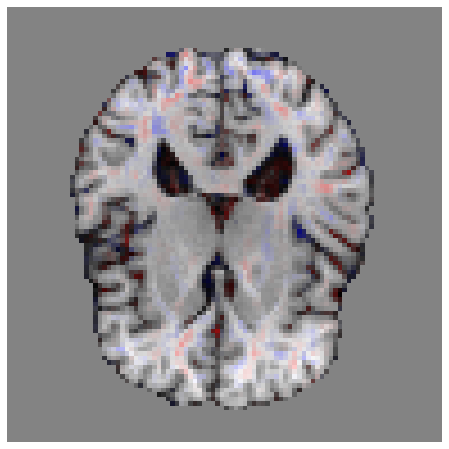

In [19]:
%matplotlib inline

plt.imshow(X_[20], cmap='gray')
plt.imshow(att_[20], cmap=ol_cmap, vmin=-1, vmax=1)
plt.axis('off')
plt.gcf().set_size_inches(8,8)
plt.show()

In [52]:
net = torch.load(PROJ_ROOT/'models/maper_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, 'cef7timl').to(device)  # pre-trained, linear lr decay
net.eval()

X, y = next(iter(val_dataloader))
X, y = X.to(device), y.to(device)

y_pred = net(X)

plt.imshow(X[20].squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

print(y_pred.mean().item(), y[0].item())

76.88679504394531 73


In [53]:
# integrated_gradients = IntegratedGradients(net)
attributions_ig = IntegratedGradients(net).attribute(X, n_steps=10)
attributions_ig.shape

torch.Size([40, 1, 96, 96])

In [67]:
%matplotlib widget

from ipywidgets import *
import matplotlib.colors as mcolors

ol_colors = [(0, 0, 1, 1-c) for c in np.linspace(0, 1, 50)] + [(1, 0, 0, c) for c in np.linspace(0, 1, 50)]
ol_cmap = mcolors.LinearSegmentedColormap.from_list('ol_cmap', ol_colors, N=100)

i = 30

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()

X_ = X.squeeze().detach().cpu()
att_ = attributions_ig.squeeze().detach().cpu()

im = ax.imshow(X_[i] * att_[i], cmap=ol_cmap)
# im_ol = ax.imshow(att_[i], cmap=ol_cmap, vmin=-.5, vmax=.5)

def update(layer):
    im.set_data(X_[layer] * att_[layer])
#     im_ol.set_data(att_[layer])

    ax.figure.canvas.draw_idle()

plt.axis('off')

plt.show()
interact(update, layer=IntSlider(min=0, max=39, step=1, value=5));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=5, description='layer', max=39), Output()), _dom_classes=('widget-intera…

In [65]:
(X_[i] * att_[i]).shape

torch.Size([96, 96])

In [64]:
att_[i].min()

tensor(-0.4681, dtype=torch.float64)

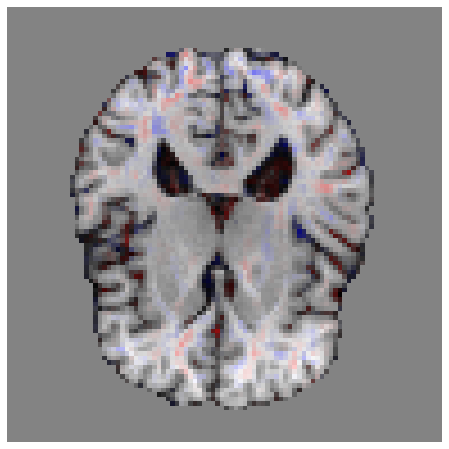

In [24]:
%matplotlib inline

X_ = X.squeeze().detach().cpu()
att_ = attributions_ig.squeeze().detach().cpu()

plt.imshow(X_[20], cmap='gray')
plt.imshow(att_[20], cmap=ol_cmap, vmin=-1, vmax=1)
plt.axis('off')
plt.gcf().set_size_inches(8,8)
plt.show()

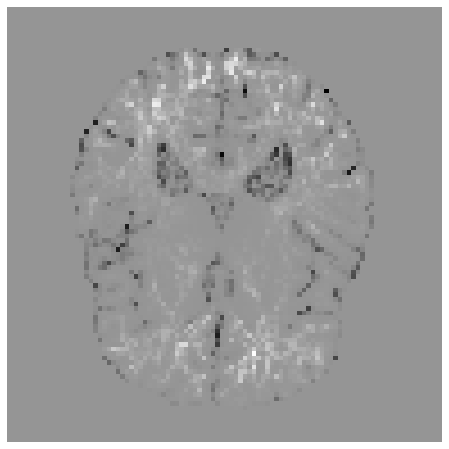

In [56]:
%matplotlib inline

X_ = X.squeeze().detach().cpu()
att_ = attributions_ig.squeeze().detach().cpu()

plt.imshow(X_[20] * att_[20].abs(), cmap='gray')
# plt.imshow(att_[20], cmap=ol_cmap, vmin=-1, vmax=1)
plt.axis('off')
plt.gcf().set_size_inches(8,8)
plt.show()

In [160]:
val_data[25*40+20]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 71)

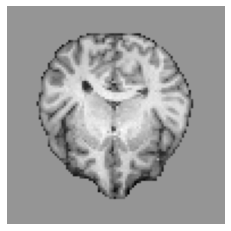

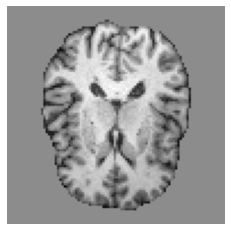

62.157508850097656 61


In [168]:
%matplotlib inline

baseline, y_baseline = val_data[25*40+20]
baseline = baseline.to(device).unsqueeze(0)

X, y = val_data[29*40+20]
X = X.to(device).unsqueeze(0)

y_pred = net(X).unsqueeze(0)

plt.imshow(X.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(baseline.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

print(y_pred.item(), y.item())

In [169]:
# integrated_gradients = IntegratedGradients(net)
attributions_ig = IntegratedGradients(net).attribute(X, baseline, n_steps=100)
attributions_ig.shape

torch.Size([1, 1, 96, 96])

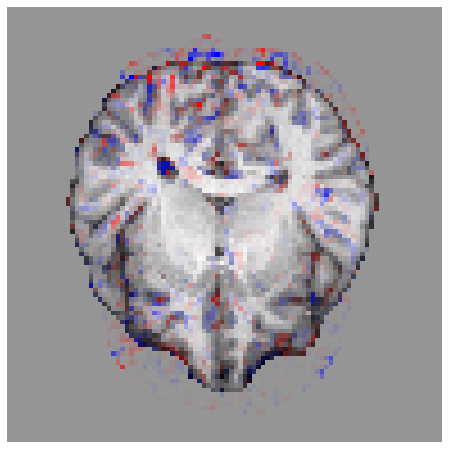

In [170]:
%matplotlib inline

X_ = X.squeeze().detach().cpu()
att_ = attributions_ig.squeeze().detach().cpu()

plt.imshow(X_, cmap='gray')
plt.imshow(att_, cmap=ol_cmap, vmin=-.5, vmax=.5)
plt.axis('off')
plt.gcf().set_size_inches(8,8)
plt.show()